In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [3]:
import numpy as np
import pandas as pd

from torchvision import models
from PIL import Image, ImageFile
from matplotlib import pyplot as plt
from tqdm import tqdm

In [4]:
from dataset import make_dataloaders, get_crop_to_opposite_original_df
from infer_utils import (
    predict_opposite_crop_to_crop,
    predict_original_to_crop,
    predict_opposite_original_to_crop,
    plot_match_pairs,
)
from utils import load_image, compute_accuracy

In [5]:
ds_path = "/home/korakova/kaggle"

Идея решения - сделать две модели: первая ищет противоположный по полу кроп, вторая ищет оригинальное изображение по кропу

Для начала протестим разные предобученные архитектуры из torchvision, попробуем брать разные фичи

train разобьем на два сплита: train и valid. Обучаемся на train, смотрим метрики на valid. 
test - это те же данные, что и на valid, но в другом формате


## Model searching

### Compute quality on valid dataset for several models

In [6]:
target_df = get_crop_to_opposite_original_df()

In [7]:
pretrained = True

In [8]:
model_names = [
    "resnet18",
    "resnext50_32x4d",
    "wide_resnet50_2",
    "vgg16",
    "squeezenet1_0",
    "densenet161",
    "mobilenet_v2",
    "mobilenet_v3_large",
    "mobilenet_v3_small",
]

In [9]:
batch_size = 1

loader_crop_crop = make_dataloaders("crop_crop", batch_size)
loader_crop_orig = make_dataloaders("crop_orig", batch_size)
device = "cuda:1"

In [10]:
result = []

for model_name in model_names:
    for features in ["local", "global"]:
        model = getattr(models, model_name)(pretrained)
        preds_crop_crop = predict_opposite_crop_to_crop(
            model, features, loader_crop_crop["test"], target_df, device
        )
        accuracy_crop_crop = compute_accuracy(
            preds_crop_crop, "path_crop_opposite", "path_crop_opposite_gt"
        )
        preds_crop_orig = predict_original_to_crop(
            model, features, loader_crop_orig["test"], target_df, device
        )
        accuracy_crop_orig = compute_accuracy(preds_crop_orig, "path_orig", "path_orig_gt")

        df_result = predict_opposite_original_to_crop(
            preds_crop_crop, preds_crop_orig, target_df
        )
        accuracy = compute_accuracy(df_result, "path_orig", "path_orig_opposite")

        result.append(
            {
                "features": features,
                "model": model_name,
                "accuracy_crop_to_crop": accuracy_crop_crop,
                "accuracy_crop_to_orig": accuracy_crop_orig,
                "accuracy": accuracy,
            }
        )

100%|██████████| 50/50 [00:01<00:00, 33.67it/s]


In [11]:
search_result = pd.DataFrame(result)

In [12]:
search_result

,features,model,accuracy_crop_to_crop,accuracy_crop_to_orig,accuracy
0,local,resnet18,0.84,0.78,0.62
1,global,resnet18,0.82,0.76,0.60
2,local,resnext50_32x4d,0.78,0.82,0.62
3,global,resnext50_32x4d,0.80,0.84,0.66
4,local,wide_resnet50_2,0.82,0.80,0.64
5,global,wide_resnet50_2,0.86,0.84,0.72
6,local,vgg16,0.92,0.78,0.70
7,global,vgg16,0.74,0.72,0.50
8,local,squeezenet1_0,0.84,0.80,0.66
9,global,squeezenet1_0,0.88,0.74,0.62


#### vgg16 + densenet161

In [18]:
features = "local"
device="cuda:1"

model = models.vgg16(pretrained)

preds_crop_crop = predict_opposite_crop_to_crop(
    model, features, loader_crop_crop["test"], target_df, device
)

accuracy_crop_crop = compute_accuracy(
    preds_crop_crop, "path_crop_opposite", "path_crop_opposite_gt"
)

model = models.densenet161(pretrained)
preds_crop_orig = predict_original_to_crop(
    model, features, loader_crop_orig["test"], target_df, device
)
accuracy_crop_orig = compute_accuracy(preds_crop_orig, "path_orig", "path_orig_gt")

df_result = predict_opposite_original_to_crop(
    preds_crop_crop, preds_crop_orig, target_df
)
accuracy = compute_accuracy(df_result, "path_orig", "path_orig_opposite")

100%|██████████| 50/50 [00:02<00:00, 20.61it/s]


In [19]:
print(f'Accuracy for crop to crop match {accuracy_crop_crop}')
print(f'Accuracy for crop to original match {accuracy_crop_orig}')
print(f'Accuracy for crop to original opposite match {accuracy}')

Accuracy for crop to crop match 0.92
Accuracy for crop to original match 0.84
Accuracy for crop to original opposite match 0.76


#### vgg16 + wide_resnet50_2

In [22]:
device="cuda:1"

model = models.vgg16(pretrained)

preds_crop_crop = predict_opposite_crop_to_crop(
    model, "local", loader_crop_crop["test"], target_df, device
)

accuracy_crop_crop = compute_accuracy(
    preds_crop_crop, "path_crop_opposite", "path_crop_opposite_gt"
)

model = models.wide_resnet50_2(pretrained)
preds_crop_orig = predict_original_to_crop(
    model, "global", loader_crop_orig["test"], target_df, device
)
accuracy_crop_orig = compute_accuracy(preds_crop_orig, "path_orig", "path_orig_gt")

df_result = predict_opposite_original_to_crop(
    preds_crop_crop, preds_crop_orig, target_df
)
accuracy = compute_accuracy(df_result, "path_orig", "path_orig_opposite")

100%|██████████| 50/50 [00:01<00:00, 26.60it/s]


In [23]:
print(f'Accuracy for crop to crop match {accuracy_crop_crop}')
print(f'Accuracy for crop to original match {accuracy_crop_orig}')
print(f'Accuracy for crop to original opposite match {accuracy}')

Accuracy for crop to crop match 0.92
Accuracy for crop to original match 0.84
Accuracy for crop to original opposite match 0.76


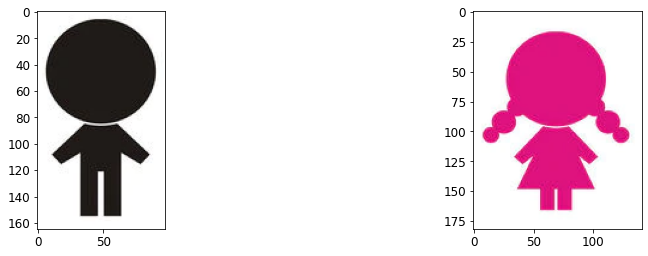

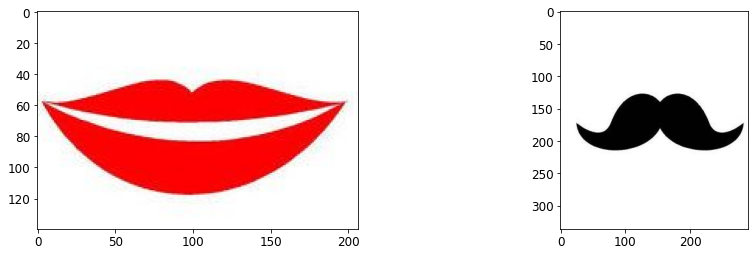

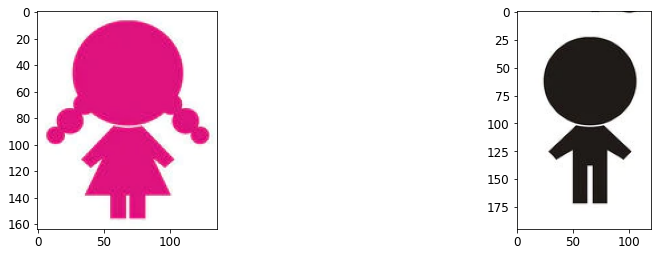

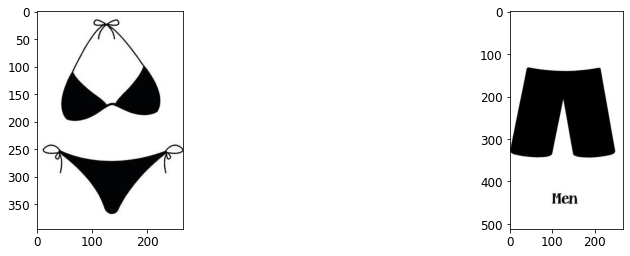

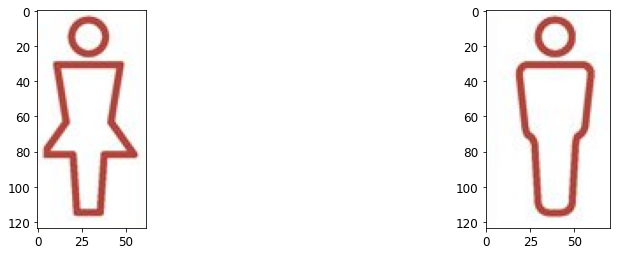

In [24]:
plot_match_pairs(df_result, 5, 'path_orig_opposite')

### Make submission

In [40]:
from dataset import make_submission_dataloader
from submission_utils import (
    predict_original_to_crop_submit,
    predict_opposite_crop_to_crop_submit,
    make_submission_file,
)

In [41]:
dataloaders = make_submission_dataloader()

In [42]:
model = models.vgg16(pretrained)
features = 'local'
preds_crop_crop = predict_opposite_crop_to_crop_submit(model, features, dataloaders['query'])

100%|██████████| 164/164 [00:18<00:00,  8.88it/s]


In [43]:
model = models.densenet161(pretrained)
features = 'local'
preds_crop_orig = predict_original_to_crop_submit(model, features, dataloaders)

100%|██████████| 164/164 [00:38<00:00,  4.27it/s]


In [44]:
submission = make_submission_file(preds_crop_crop, preds_crop_orig)

In [45]:
assert len(set(submission.DocumentNumber.values).intersection(set(submission.QueryId.values)))==0

In [46]:
test = pd.read_csv('test.csv')

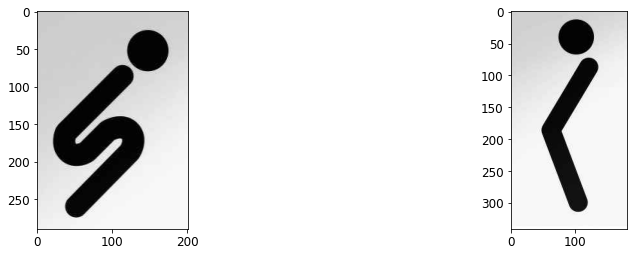

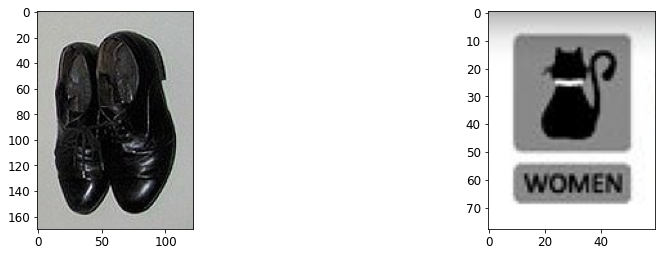

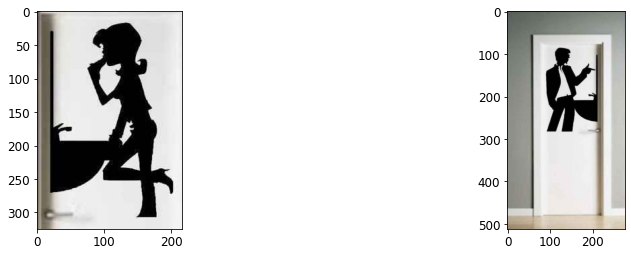

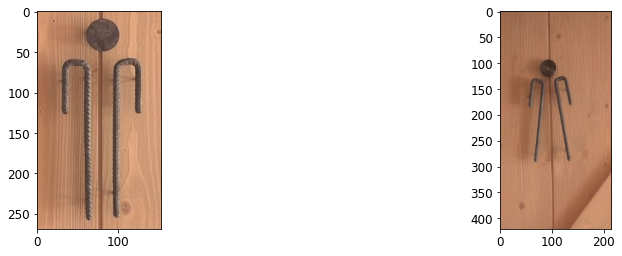

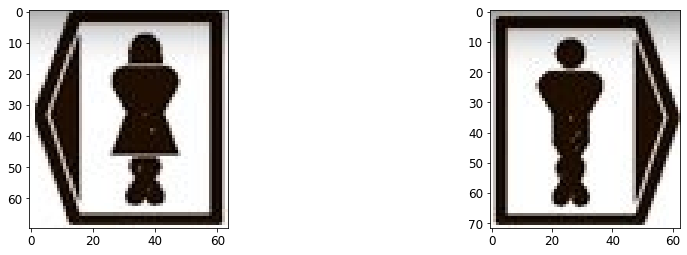

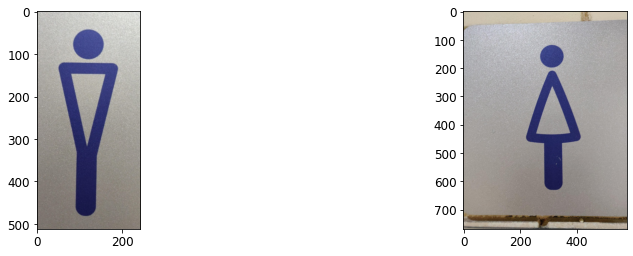

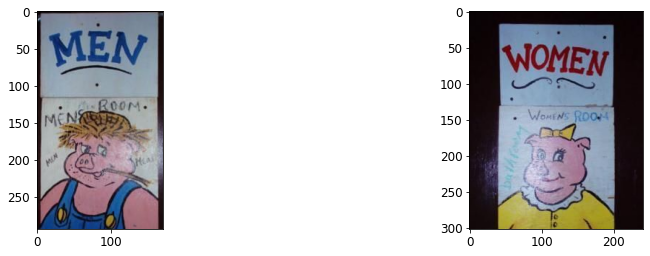

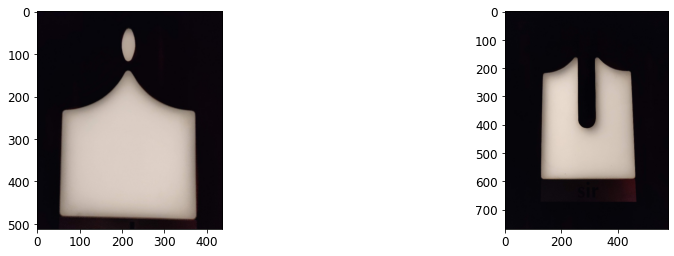

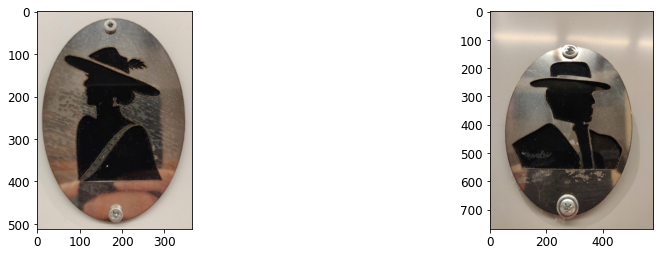

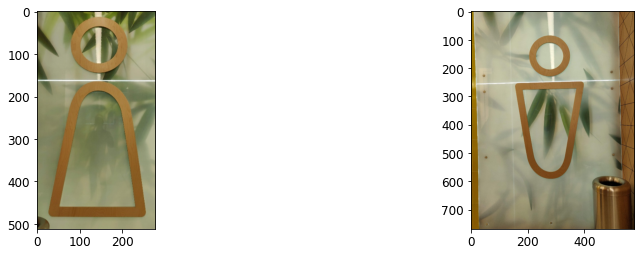

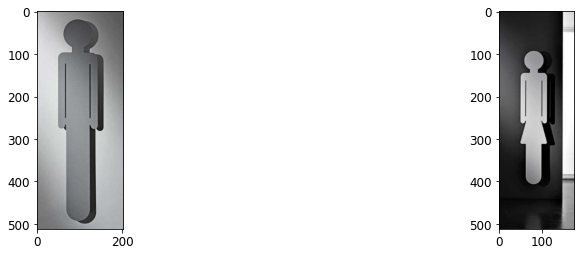

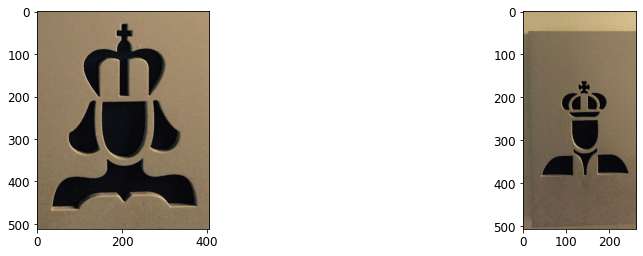

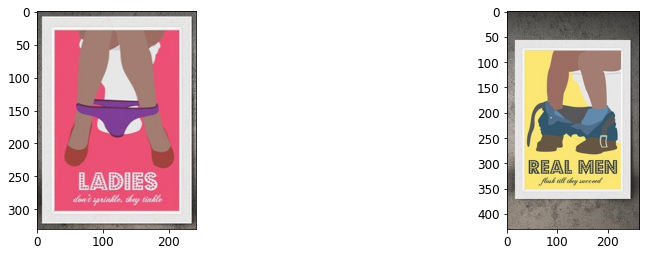

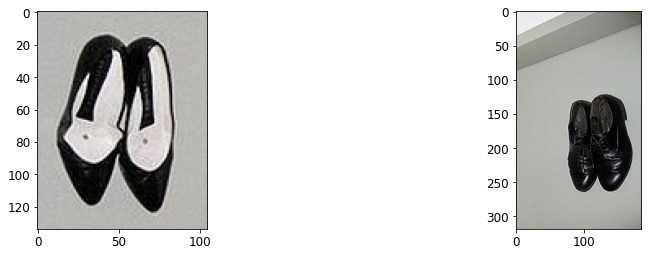

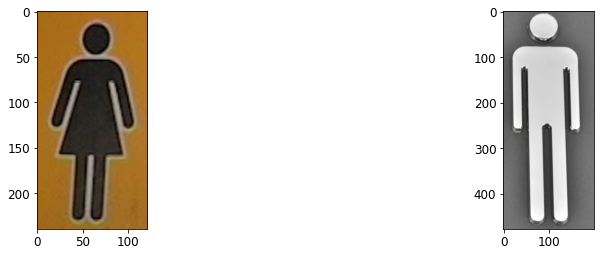

In [47]:
for i, (idx, row) in enumerate(submission.iterrows()):
    if i==15:
        break
    QueryId = row['QueryId']
    DocumentNumber = row['DocumentNumber']
    
    img_path1 = test.iloc[QueryId].path
    img_path2 = test.iloc[DocumentNumber].path
    img1 = load_image(img_path1, ds_path)
    img2 = load_image(img_path2, ds_path)
    
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    
    ax[0].imshow(img1)
    ax[1].imshow(img2)
    plt.show();

#### vgg16 + densenet161 дает больший скор, оставляем ее

In [49]:
submission.to_csv('submission_model_search.csv', index=False)